In [20]:
!nvidia-smi

Tue Apr 19 08:47:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    35W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
from google.colab import drive
import sys
drive.mount('/content/drive')
#设置路径
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
! pip install transformers==4.0.1

In [46]:
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

config = {
    'train_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/train.json',
    'dev_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/dev.json',
    'test_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/ESIM/test.json',
    'embedding_file_path':'/content/drive/MyDrive/Colab Notebooks/dataset/sgns.weibo.word.bz2',
    'train_val_ratio':0.1,
    'vocab_size':30000,
    'batch_size':64,
    # 从后面可以看出 64能容纳99%的句子长度
    'max_seq_len':64,
    'num_epochs':1,
    'learning_rate':2e-5,
    'logging_step':500,
    'seed':2022
}

config['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  return seed

seed_everything(config['seed'])

2022

In [24]:
import json
def read_data(path):
  sentence_a = []
  sentence_b = []
  labels = []
  with open(path, 'r', encoding='utf8') as f:
    for line in tqdm(f.readlines(), desc='Reading data'):
      line = json.loads(line)
      sentence_a.append(line['sentence1'])
      sentence_b.append(line['sentence2'])
      labels.append(int(line['label']))
  
  df = pd.DataFrame(zip(sentence_a, sentence_b, labels), columns=['text_a','text_b','labels'])
  return df

In [25]:
# 复习一下zip函数:
# 这里有两个元组()，每个元组有两个句子，一个label
datas = [([1,2,3],[4,5,6],1),([777,888,999],[321,543,654],0)]
# 取出列表中每个元素（元组）
print(*datas)
print(zip(*datas))
# 把 datas 中的同一类别的放在一起
print(list(zip(*datas)))

([1, 2, 3], [4, 5, 6], 1) ([777, 888, 999], [321, 543, 654], 0)
[([1, 2, 3], [777, 888, 999]), ([4, 5, 6], [321, 543, 654]), (1, 0)]


In [26]:
train_df = read_data(config['train_file_path'])

Reading data: 100%|██████████| 34334/34334 [00:00<00:00, 78693.38it/s]


In [27]:
train_df.head()

,text_a,text_b,labels
0,蚂蚁借呗等额还款可以换成先息后本吗,借呗有先息到期还本吗,0
1,蚂蚁花呗说我违约一次,蚂蚁花呗违约行为是什么,0
2,帮我看一下本月花呗账单有没有结清,下月花呗账单,0
3,蚂蚁借呗多长时间综合评估一次,借呗得评估多久,0
4,我的花呗账单是***，还款怎么是***,我的花呗，月结出来说让我还***元，我自己算了一下详细名单我应该还***元,1


In [28]:
dev_df = read_data(config['dev_file_path'])

Reading data: 100%|██████████| 4316/4316 [00:00<00:00, 63881.74it/s]


In [29]:
dev_df.head()

,text_a,text_b,labels
0,双十一花呗提额在哪,里可以提花呗额度,0
1,花呗支持高铁票支付吗,为什么友付宝不支持花呗付款,0
2,我的蚂蚁花呗支付金额怎么会有限制,我到支付宝实体店消费用花呗支付受金额限制,1
3,为什么有花呗额度不能分期付款,花呗分期额度不足,0
4,赠品不能设置用花呗付款,怎么不能花呗分期付款,0


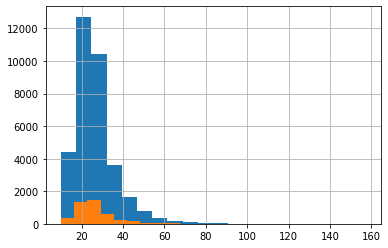

In [30]:
(train_df.text_a.str.len() + train_df.text_b.str.len()).hist(bins = 20);
(dev_df.text_a.str.len() + dev_df.text_b.str.len()).hist(bins = 20);

In [31]:
# 64能容纳99%的句子长度
(train_df.text_a.str.len() + train_df.text_b.str.len()).quantile(0.99)

64.0

In [32]:
# 处理文件，生层词表放回关于train_df[train.json + dev.json],test_df
from collections import Counter
import jieba
import bz2
def preprocess(config):
  def convert2df(file_path, dataset='train'):
    sentence_a = []
    sentence_b = []
    labels = []
    with open(file_path, 'r', encoding='utf8') as f:
      for line in tqdm(f.readlines(), desc=f'Reading {dataset} data'):
        line = json.loads(line)
        sentence_a.append(line['sentence1'])
        sentence_b.append(line['sentence2'])
        if dataset != 'test':
          labels.append(int(line['label']))
        else:
          labels.append(0)
        # tokens为每次新加入的句子
        tokens = list(jieba.cut(sentence_a[-1])) + list(jieba.cut(sentence_b[-1])) 
        # print('tokens:',tokens)
        # tokens: ['蚂蚁', '花', '呗', '说', '我', '违约', '一次', '蚂蚁', '花', '呗', '违约', '行为', '是', '什么']
        token_counter.update(tokens)
    df = pd.DataFrame(zip(sentence_a,sentence_b,labels),columns=['text_a','text_b','labels'])
    return df
  
  token_counter = Counter()

  train_df = convert2df(config['train_file_path'],'train')
  dev_df = convert2df(config['dev_file_path'],'dev')
  test_df = convert2df(config['test_file_path'],'test')

  train_df = train_df.append(dev_df)
  vocab = set(token for token, _ in token_counter.most_common(config['vocab_size']))
  # print('vocab:',vocab)
  # vocab: {'城', '帮不上', '百度', '钱分', '会加分', '我晚', '手机短信'.......}
  return train_df, test_df, vocab



In [33]:
train_df, test_df, vocab = preprocess(config)

Reading test data: 100%|██████████| 3861/3861 [00:00<00:00, 4353.15it/s]


In [34]:
# TextCNN 词表对应成向量
def get_embedding(vocab, embedding_file_path):
  print('processing embedding file, please wait...')

  token2embedding = {}

  with bz2.open(embedding_file_path) as f:
    token_vectors = f.readlines()
    # print('token_vectors:',list(token_vectors[0:10]))
    # token_vectors: [b'195202 300\n', b'\xef\xbc\x8c 0.094386 -0.200944 -0.030828 0.277130 ... 0.126182 -0.554329 -0.328050 \n', b'......\n'...]
    meta_info = token_vectors[0].split()
    # print('meta_info:',meta_info)
    # meta_info: [b'195202', b'300']
    print(f'{meta_info[0]} tokens in embedding file in total, vector size is {meta_info[-1]}')

    for line in tqdm(token_vectors[1:]):
      line = line.split()
      token = line[0].decode('utf8')
      # print('token:',token)
      # token: ！
      # token: 可以
      # token: 等
      # ...
      vector = line[1:]
      if token in vocab:
        token2embedding[token] = [float(num) for num in vector]
        # print('token2embedding[token]:',token2embedding[token])
        # token2embedding[token]: [-0.124044, -0.053688, 0.157958, ... -0.127075, -0.020528, 0.032646]
  #从4开始
  token2idx = {token: idx for idx, token in enumerate(token2embedding.keys(),4)}
  UNK, PAD, BOS, EOS = '<unk>', '<pad>', '<bos>', '<eos>'
  token2idx[PAD] = 0 
  token2idx[UNK] = 1
  token2idx[BOS] = 2
  token2idx[EOS] = 3
  idx2token = {idx: token for token, idx in token2idx.items()}
  idx2embedding = {token2idx[token]: embedding for token, embedding in token2embedding.items()}

  idx2embedding[0] = [.0] * int(meta_info[-1])
  idx2embedding[1] = [.0] * int(meta_info[-1])
  idx2embedding[2] = np.random.random(int(meta_info[-1])).tolist()
  idx2embedding[3] = np.random.random(int(meta_info[-1])).tolist()
  emb_mat = [idx2embedding[idx] for idx in range(len(idx2embedding))]

  return torch.tensor(emb_mat, dtype=torch.float), token2idx, len(vocab) + 4

In [35]:
embedding_matrix, token2idx, config['vocab_size'] = get_embedding(vocab, config['embedding_file_path'])

processing embedding file, please wait...
b'195202' tokens in embedding file in total, vector size is b'300'


100%|██████████| 195202/195202 [00:03<00:00, 56866.28it/s]


In [36]:
from collections import defaultdict
def tokenizer(sent, token2id):
  # .get() 找到返回 token的id, 没找到就返回 1 1->UNK
  ids = [token2id.get(token, 1) for token in jieba.cut(sent)]
  return ids

```
df = pd.DataFrame(np.random.randn(4, 3), columns = ['col1', 'col2', 'col3'])
df

	col1	  col2	   col3
0	0.956880	0.787811	0.099237
1	0.413166	-0.541869	0.548336
2	0.951179	0.113981	1.130187
3	0.802346	1.953860	-2.062042

for i, row in df.iterrows():
  print('i:',i,'row:',row)

i: 0 row: col1    0.956880
col2    0.787811
col3    0.099237
Name: 0, dtype: float64
i: 1 row: col1    0.413166
col2   -0.541869
col3    0.548336
Name: 1, dtype: float64
i: 2 row: col1    0.951179
col2    0.113981
col3    1.130187
Name: 2, dtype: float64
i: 3 row: col1    0.802346
col2    1.953860
col3   -2.062042
Name: 3, dtype: float64

for i, row in df.iterrows():
  print('row[0]:',row[0])

row[0]: 0.9568798249976214
row[0]: 0.41316597459220283
row[0]: 0.9511794577235149
row[0]: 0.8023455023210482
```

In [37]:
def read_data(data_df, train_val_ratio, token2id, mode = 'train'):
  if mode == 'train':
    X_train, y_train = defaultdict(list),[]
    X_val, y_val = defaultdict(list),[]
    num_val = int(len(data_df) * train_val_ratio)
  else:
    X_test, y_test = defaultdict(list),[]
  
  for i, row in tqdm(data_df.iterrows(), desc=f'Preprocessing {mode} data', total = len(data_df)):
    text_left = row[0]
    text_right = row[1]
    label = row[2]

    input_a = tokenizer(text_left, token2id = token2idx)
    input_b = tokenizer(text_right, token2id = token2idx)
    
    if mode == 'train':
      if i<num_val:
        X_val['text_left'].append(input_a)
        X_val['text_right'].append(input_b)
        y_val.append(label)
      else:
        X_train['text_left'].append(input_a)
        X_train['text_right'].append(input_b)
        y_train.append(label)
    else:
      X_test['text_left'].append(input_a)
      X_test['text_right'].append(input_b)
      y_test.append(label)

  if mode == 'train':
    label2id = {label : i for i,label in enumerate(np.unique(y_train))}
    id2label = {i : label for label, i in label2id.items()}
    y_train = torch.tensor([label2id[label] for label in y_train], dtype= torch.long)
    y_val = torch.tensor([label2id[label] for label in y_val], dtype= torch.long)
    return X_train, y_train, X_val, y_val, label2id, id2label
  else:
    y_test = torch.tensor(y_test, dtype=torch.long)
    return X_test, y_test

In [38]:
X_train, y_train, X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], token2idx, mode='train')
X_test, y_test = read_data(test_df, config['train_val_ratio'], token2idx, mode='test')

Preprocessing test data: 100%|██████████| 3861/3861 [00:01<00:00, 3022.47it/s]


In [39]:
from torch.utils.data import Dataset
class AFQMCDataset(Dataset):
  def __init__(self, x, y):
    super(AFQMCDataset, self).__init__()
    self.x = x
    self.y = y
  
  def __getitem__(self, idx):
    data = (self.x['text_left'][idx],
         self.x['text_right'][idx],
         self.y[idx]   
            )
    return data
  
  def __len__(self):
    return self.y.size(0)#行数

```
TextCNN中collete_fn函数
def collete_fn(examples):
    input_ids_list = []
    labels =[]
    for example in examples:
        input_ids_list.append(example['input_ids'])
        labels.append(example['label'])

    # 对齐操作 -- 找到 input_ids_list 中 最长的 句子， 执行短句子补齐
    # 1. 找到 input_ids_list 中 最长的 句子
    max_length = max(len(input_ids) for input_ids in input_ids_list) 
    # 2. 定义一个 input_ids_tensor, 我们要把 每个 input_ids 放入 tensor 中
    input_ids_tensor = torch.zeros((len(labels), max_length), dtype=torch.long)
    for i, input_ids in enumerate(input_ids_list):
        # 得到当前句子的长度
        seq_len = len(input_ids)
        # 第i个句子，填充 seq_len 这么长
        input_ids_tensor[i, :seq_len] = torch.tensor(input_ids, dtype=torch.long)

    return {
        'input_ids' : input_ids_tensor,
        'labels' : torch.tensor(labels, dtype=torch.long)
    }
```

In [40]:
# __call__方法的调用
class MyClass():
  def __call__(self):
    print('__call__方法被调用')
    return 'done'

In [41]:
# 类实例化
obj = MyClass()

In [42]:
# 实例化的对象 当作函数用
res = obj()

__call__方法被调用


In [43]:
# 从 AFQMCDataset 输出的 data  = (sentence1, sentence2, label])
# 1. 将元组中属于sentence1的放在一起，属于sentence2的放在一起，属于label的放在一起
# 2. 对齐操作，找到sentence1, sentence2,最长的句子，执行短句子补齐
# 3. 定义一个tensor，把数据放里面

class Collator:
  def __init__(self, max_seq_len):
    self.max_seq_len = max_seq_len
  
  def get_max_seq_len(self, ids_list):
    cur_max_seq_len = max(len(input_id) for input_id in ids_list)
    max_seq_len = min (self.max_seq_len, cur_max_seq_len)
    return max_seq_len
  
  def pad_and_truncate(text_ids_list, max_seq_len):
    input_ids = torch.zeros((len(text_ids_list), max_seq_len),dtype=torch.long)
    for i, text_ids in enumerate(text_ids_list):
      seq_len = min(len(text_ids), max_seq_len)
      input_ids[i, :seq_len] = torch.tensor(text_ids[:seq_len],dtype=torch.long)
    return input_ids

  def __call__(self, examples):
    # 1. 将元组中属于sentence1的放在一起，属于sentence2的放在一起，属于label的放在一起
    text_ids_left_list, text_ids_right_list, labels_list = list(zip(*examples))
    # 2.1 找到 text_ids_left_list, text_ids_right_list 最长的句子长度
    max_text_left_length = self.get_max_seq_len(text_ids_left_list)
    max_text_right_length = self.get_max_seq_len(text_ids_right_list)

    # 2.2 执行短句子补齐, 3.定义一个tensor，把数据放里面
    text_left_ids = self.pad_and_truncate(text_ids_left_list, max_text_left_length)
    text_right_ids = self.pad_and_truncate(text_ids_right_list, max_text_right_length)
    labels = torch.tensor(labels_list, dtype = torch.long)

    data_list = [text_left_ids, text_right_ids, labels]
    return data_list

In [44]:
from torch.utils.data import DataLoader
def build_dataloader(train_df, test_df, config, vocab):
  X_train, y_train ,X_val, y_val, label2id, id2label = read_data(train_df, config['train_val_ratio'], vocab, mode='train')
  X_test, y_test = read_data(test_df, config['train_val_ratio'], vocab, mode='test')

  train_dataset = AFQMCDataset(X_train, y_train)
  val_dataset = AFQMCDataset(X_val, y_val)
  test_dataset = AFQMCDataset(X_test, y_test)
  
  collate_fn = Collator(config['max_seq_len'])

  train_dataloader = DataLoader(dataset = train_dataset, batch_size = config['batch_size'], num_workers = 4, shuffle = True, collate_fn = collate_fn)
  val_dataloader = DataLoader(dataset = val_dataset, batch_size = config['batch_size'], num_workers = 4, shuffle = False, collate_fn = collate_fn)
  test_dataloader = DataLoader(dataset = test_dataset, batch_size = config['batch_size'], num_workers = 4, shuffle = False, collate_fn = collate_fn)

  return id2label, test_dataloader, val_dataloader, train_dataloader

In [47]:
id2label, test_dataloader, val_dataloader, train_dataloader = build_dataloader(train_df, test_df, config, token2idx)

Preprocessing test data: 100%|██████████| 3861/3861 [00:01<00:00, 2957.27it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
